In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from nilearn.signal import clean
import pandas as pd
from scipy.stats import linregress
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSCanonical
from sklearn.decomposition import PCA
import statsmodels.formula.api as smf
import statsmodels.api as sm
from tqdm import tqdm

In [ ]:
# Initialize
PATH = '...'
categories = ['DEL', 'DUP']

# Initialize functions
scaler = StandardScaler()

Load data

In [ ]:
# Baseline
# Load genetic data
df_cnv = pd.read_csv(PATH + '....csv')
df_cnv = df_cnv[df_cnv['TYPE'].isin(['DEL', 'DUP', 'CTRL', 'BOTH'])]  # keep only data with genetic info
idx_cnv = df_cnv[df_cnv['TYPE'].isin(['DEL', 'DUP', 'BOTH'])].SampleID.values
df_cnv.set_index('SampleID', inplace=True)
# Genetic covariates
df_cnv = df_cnv.loc[:, ['TYPE', 'sum_loeuf_inv', 'n_genes', 'gene_id']]

# Load clean data
df_brain = pd.read_csv(PATH + '....csv', index_col=0)
df_phens = pd.read_csv(PATH + '....csv', index_col=0)
df_cov = pd.read_csv(PATH + '....csv', index_col=0)

In [ ]:
# Unite data
idx_str = df_brain.index
idx_phens = df_phens.index
idx_genetic = df_cnv.index
idx_cov = df_cov.index

idx_all = list(set(idx_str) & set(idx_phens) & set(idx_genetic) & set(idx_cov))
idx_cnv = np.intersect1d(idx_cnv, idx_all)
idx_ctrl = np.setdiff1d(idx_all, idx_cnv)

df_cnv = df_cnv.loc[idx_all, :]
df_brain = df_brain.loc[idx_all, :]
df_phens = df_phens.loc[idx_all, :]
df_cov = df_cov.loc[idx_all, :]

In [ ]:
# Baseline without age
df_brain_base = pd.DataFrame(df_brain)
df_brain_base[:] = clean(df_brain_base.values, confounds=df_cov.loc[:, ['sex', 'volume', 'scanner']].values,
                         detrend=False, standardize=False)


Followup data

In [ ]:
# Load clean data
df_brain_follow = pd.read_csv(PATH + '....csv', index_col=0)
df_cov_follow = pd.read_csv(PATH + '....csv', index_col=0)


In [ ]:
# Unite data
idx_str = df_brain_follow.index
idx_genetic = df_cnv.index
idx_cov = df_cov_follow.index

idx_all = list(set(idx_str) & set(idx_genetic) & set(idx_cov))
idx_cnv2 = np.intersect1d(idx_cnv, idx_all)
idx_ctrl2 = np.setdiff1d(idx_all, idx_cnv2)

df_cnv_follow = df_cnv.loc[idx_all, :]
df_brain_follow = df_brain_follow.loc[idx_all, :]
df_cov_follow = df_cov_follow.loc[idx_all, :]

In [ ]:
df_brain_follow[:] = clean(df_brain_follow.values,
                           confounds=df_cov_follow.loc[:, ['sex', 'volume', 'scanner']].values,
                           detrend=False, standardize=False)

Z-score and PCA data

In [ ]:
# Prepare data
scaler = StandardScaler()

# z-score separately for CTRL and CNV based on baseline
scaler.fit(df_brain_base.values.astype('float')[df_cnv['TYPE'] == 'CTRL'])  # fit on CTRL
df_brain_base[:] = scaler.fit_transform(df_brain_base.values)
df_brain_follow[:] = scaler.transform(df_brain_follow.values)

x_ctrl1_ss = df_brain_base.values.astype('float')[df_cnv['TYPE'] == 'CTRL']

scaler.fit(df_phens.values.astype('float')[df_cnv['TYPE'] == 'CTRL'])
df_phens[:] = scaler.transform(df_phens.values)

y_ctrl_ss = df_phens.values.astype('float')[df_cnv['TYPE'] == 'CTRL']

In [ ]:
# Reduce data with PCA
pca_x = PCA(n_components=50)
pca_y = PCA(n_components=50)
x_ctrl1_ss_pca = pca_x.fit_transform(x_ctrl1_ss)
y_ctrl_pca = pca_y.fit_transform(y_ctrl_ss)

PLS machinery

In [ ]:
# Run PLS model
ndim = 3
pls = PLSCanonical(n_components=ndim, scale=False, max_iter=100000, tol=1e-9, algorithm='nipals')
pls.fit(x_ctrl1_ss_pca, y_ctrl_pca)

PLSCanonical(max_iter=100000, n_components=3, scale=False, tol=1e-09)

In [21]:
# PLS parameters
x_rotations_ = pls.x_rotations_
x_rotations_ = pca_x.inverse_transform(x_rotations_.T).T

Join dataframes

In [ ]:
df_brain = pd.merge(df_brain_base, df_brain_follow,
                  left_index=True, right_index=True, how='inner')

# Separate data from baseline and follow-up
x_ctrl1_ss = df_brain.loc[df_cnv.loc[df_brain.index, :]
                        ['TYPE'] == 'CTRL', :].iloc[:, :148].values
x_ctrl2_ss = df_brain.loc[df_cnv.loc[df_brain.index, :]
                        ['TYPE'] == 'CTRL', :].iloc[:, 148:].values

x_del1_ss = df_brain.loc[df_cnv.loc[df_brain.index, :]
                       ['TYPE'].isin(['DEL', 'BOTH']), :].iloc[:, :148].values
x_del2_ss = df_brain.loc[df_cnv.loc[df_brain.index, :]
                       ['TYPE'].isin(['DEL', 'BOTH']), :].iloc[:, 148:].values

x_dup1_ss = df_brain.loc[df_cnv.loc[df_brain.index, :]
                       ['TYPE'].isin(['DUP', 'BOTH']), :].iloc[:, :148].values
x_dup2_ss = df_brain.loc[df_cnv.loc[df_brain.index, :]
                       ['TYPE'].isin(['DUP', 'BOTH']), :].iloc[:, 148:].values


Compare baseline and follow-up

100%|██████████| 148/148 [00:00<00:00, 10889.52it/s]


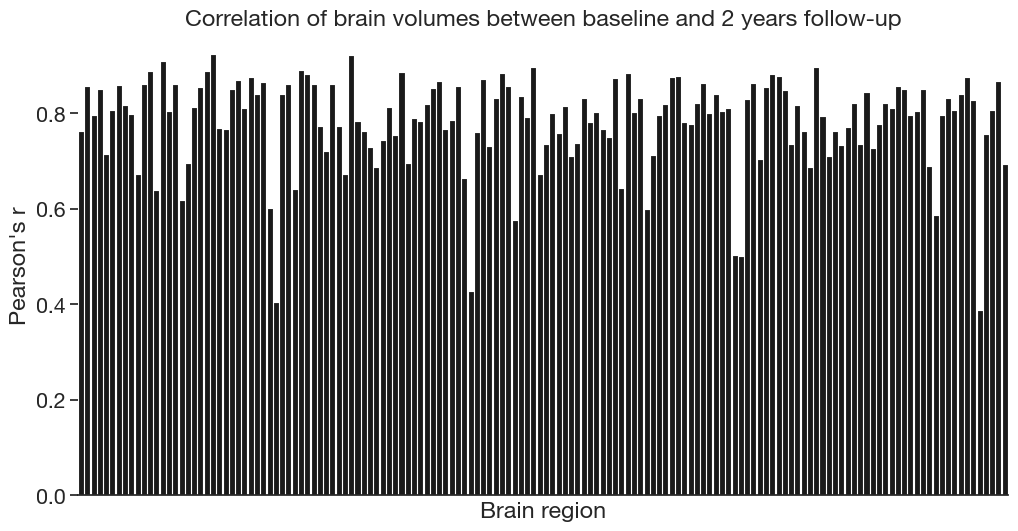

In [ ]:
X = np.zeros(148)
for i in tqdm(range(148)):
    X[i] = np.corrcoef(x_ctrl1_ss[:, i], x_ctrl2_ss[:, i])[0, 1]

fig, ax = plt.subplots(1, figsize=(12, 6))
sns.barplot(x=np.arange(1, 149), y=X, color='k', linewidth=0.1)
ax.set_xlabel('Brain region')
ax.set_ylabel("Pearson's r")
ax.set_xticks([])
ax.set_title('Correlation of brain volumes between baseline and 2 years follow-up')
plt.show()

In [ ]:
# Calculate scores for baseline and follow-up
x_score_ctrl1 = np.dot(x_ctrl1_ss, x_rotations_)
x_score_ctrl2 = np.dot(x_ctrl2_ss, x_rotations_)

x_score_del1 = np.dot(x_del1_ss, x_rotations_)
x_score_del2 = np.dot(x_del2_ss, x_rotations_)

x_score_dup1 = np.dot(x_dup1_ss, x_rotations_)
x_score_dup2 = np.dot(x_dup2_ss, x_rotations_)

Plot PLS scores for given PLS mode

In [ ]:
dim=2
idx_ctrl = df_brain.loc[df_cnv.loc[df_brain.index, :]['TYPE'] == 'CTRL', :].index  # get subject indices for CTRL
age_ctrl1 = df_cov.loc[idx_ctrl, 'interview_age'].values  # age at baseline
age_ctrl2 = df_cov_follow.loc[idx_ctrl, 'interview_age'].values  # age at follow-up
df_ctrl1 = pd.DataFrame({'age': age_ctrl1, 'score': x_score_ctrl1[:, dim]})  # age and score at baseline
df_ctrl2 = pd.DataFrame({'age': age_ctrl2, 'score': x_score_ctrl2[:, dim]})  # age and score at follow-up
df_ctrl = pd.DataFrame({'age': np.concatenate((age_ctrl1, age_ctrl2)),
                        'score': np.concatenate((x_score_ctrl1[:, dim], x_score_ctrl2[:, dim]))})
df_ctrl = df_ctrl.sort_values(by='age')

idx_del = df_brain.loc[df_cnv.loc[df_brain.index, :]['TYPE'].isin(['DEL', 'BOTH']), :].index  # get subject indices for DEL
age_del1 = df_cov.loc[idx_del, 'interview_age'].values
age_del2 = df_cov_follow.loc[idx_del, 'interview_age'].values
df_del1 = pd.DataFrame({'age': age_del1, 'score': x_score_del1[:, dim]})
df_del2 = pd.DataFrame({'age': age_del2, 'score': x_score_del2[:, dim]})
df_del = pd.DataFrame({'age': np.concatenate((age_del1, age_del2)),
                       'score': np.concatenate((x_score_del1[:, dim], x_score_del2[:, dim]))})
df_del = df_del.sort_values(by='age')

idx_dup = df_brain.loc[df_cnv.loc[df_brain.index, :]['TYPE'].isin(['DUP', 'BOTH']), :].index  # get subject indices for DUP
age_dup1 = df_cov.loc[idx_dup, 'interview_age'].values
age_dup2 = df_cov_follow.loc[idx_dup, 'interview_age'].values
df_dup1 = pd.DataFrame({'age': age_dup1, 'score': x_score_dup1[:, dim]})
df_dup2 = pd.DataFrame({'age': age_dup2, 'score': x_score_dup2[:, dim]})
df_dup = pd.DataFrame({'age': np.concatenate((age_dup1, age_dup2)),
                       'score': np.concatenate((x_score_dup1[:, dim], x_score_dup2[:, dim]))})
df_dup = df_dup.sort_values(by='age')

# Get limits for plotting
xmin = np.min(np.concatenate((age_ctrl1, age_ctrl2,
                              age_del1, age_del2,
                              age_dup1, age_dup2)))-2
xmax = np.max(np.concatenate((age_ctrl1, age_ctrl2,
                              age_del1, age_del2,
                              age_dup1, age_dup2)))+2
ymin = np.min(np.concatenate((x_score_ctrl1[:, dim], x_score_ctrl2[:, dim],
                              x_score_del1[:, dim], x_score_del2[:, dim],
                              x_score_dup1[:, dim], x_score_dup2[:, dim])))-0.2
ymax = np.max(np.concatenate((x_score_ctrl1[:, dim], x_score_ctrl2[:, dim],
                              x_score_del1[:, dim], x_score_del2[:, dim],
                              x_score_dup1[:, dim], x_score_dup2[:, dim])))+0.2    

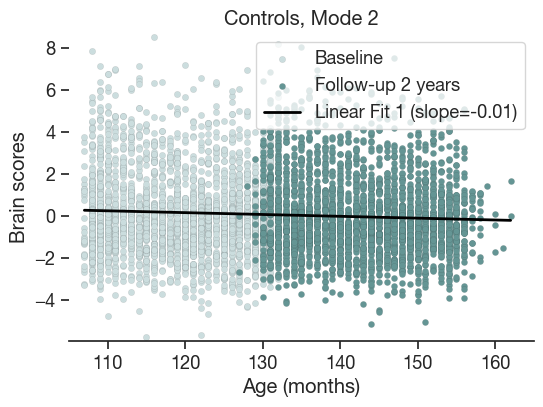

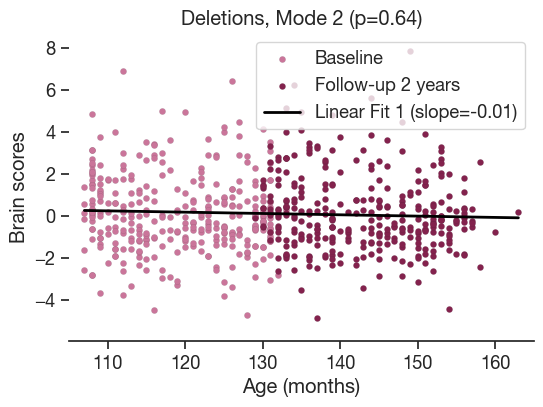

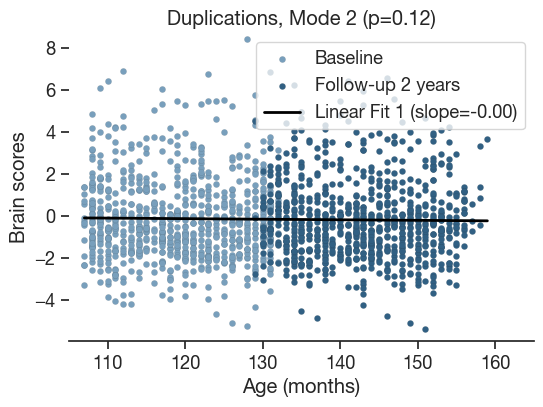

In [ ]:
# Plot scatterplot of brain scores and age for CTRL
fig, ax = plt.subplots(1, figsize=(6, 4))
sns.scatterplot(x='age', y='score', data=df_ctrl1,
                label='Baseline', alpha=1, s=20, edgecolor='k', linewidth=0.05)
sns.scatterplot(x='age', y='score', data=df_ctrl2,
                label='Follow-up 2 years', alpha=1, s=20, edgecolor='k', linewidth=0.05)
# Linear regression for Dataset 1
slope1, intercept1, r_value1, p_value1, std_err1 = linregress(df_ctrl['age'], df_ctrl['score'])
plt.plot(df_ctrl['age'], slope1 * df_ctrl['age'] + intercept1, color='black', label=f'Linear Fit 1 (slope={slope1:.2f})', linewidth=2)
plt.legend(loc='upper right')
ax.set_xlabel('Age (months)')
ax.set_ylabel('Brain scores')
ax.set_title('Controls, Mode ' + str(dim+1))
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
plt.show()

# Plot scatterplot of brain scores and age for DEL
fig, ax = plt.subplots(1, figsize=(6, 4))
sns.scatterplot(x='age', y='score', data=df_del1,
                label='Baseline', alpha=1, s=20, edgecolor='k', linewidth=0.05)
sns.scatterplot(x='age', y='score', data=df_del2,
                label='Follow-up 2 years', alpha=1, s=20, edgecolor='k', linewidth=0.05)
# Linear regression for Dataset 1
slope2, intercept2, r_value2, p_value2, std_err2 = linregress(df_del['age'], df_del['score'])
plt.plot(df_del['age'], slope2 * df_del['age'] + intercept2, color='black', label=f'Linear Fit 1 (slope={slope2:.2f})', linewidth=2)
plt.legend(loc='upper right')
ax.set_xlabel('Age (months)')
ax.set_ylabel('Brain scores')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
plt.show()

# Plot scatterplot of brain scores and age for DUP
fig, ax = plt.subplots(1, figsize=(6, 4))
sns.scatterplot(x='age', y='score', data=df_dup1,
                label='Baseline', alpha=1, s=20, edgecolor='k', linewidth=0.05)
sns.scatterplot(x='age', y='score', data=df_dup2,
                label='Follow-up 2 years', alpha=1, s=20, edgecolor='k', linewidth=0.05)
# Linear regression for Dataset 1
slope3, intercept3, r_value3, p_value3, std_err3 = linregress(df_dup['age'], df_dup['score'])
plt.plot(df_dup['age'], slope3 * df_dup['age'] + intercept3, color='black', label=f'Linear Fit 1 (slope={slope3:.2f})', linewidth=2)
plt.legend(loc='upper right')
ax.set_xlabel('Age (months)')
ax.set_ylabel('Brain scores')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
plt.show()

Linear regression model for CTRL

In [ ]:
dim=2
idx_ctrl = df_brain.loc[df_cnv.loc[df_brain.index, :]['TYPE'] == 'CTRL', :].index
age_ctrl1 = df_cov.loc[idx_ctrl, 'interview_age'].values
age_ctrl2 = df_cov_follow.loc[idx_ctrl, 'interview_age'].values
df_ctrl1 = pd.DataFrame({'age': age_ctrl1, 'score': x_score_ctrl1[:, dim]})
df_ctrl2 = pd.DataFrame({'age': age_ctrl2, 'score': x_score_ctrl2[:, dim]})
df_ctrl = pd.DataFrame({'age': np.concatenate((age_ctrl1, age_ctrl2)),
                        'score': np.concatenate((x_score_ctrl1[:, dim], x_score_ctrl2[:, dim]))})
df_ctrl = df_ctrl.sort_values(by='age')
# Add a constant to the predictor to include the intercept in the model
x_with_const = sm.add_constant(df_ctrl['age'])
# Fit the linear regression model
model = sm.OLS(df_ctrl['score'], x_with_const).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     20.79
Date:                Mon, 04 Nov 2024   Prob (F-statistic):           5.24e-06
Time:                        14:47:35   Log-Likelihood:                -9677.4
No. Observations:                5216   AIC:                         1.936e+04
Df Residuals:                    5214   BIC:                         1.937e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.8909      0.201     -4.437      0.0

Mixed-effects model for DUP

In [ ]:
df = pd.DataFrame({'brain_score1': np.concatenate((x_score_ctrl1[:, 0], x_score_ctrl2[:, 0],
                                                   x_score_dup1[:, 0], x_score_dup2[:, 0])),
                   'brain_score2': np.concatenate((x_score_ctrl1[:, 1], x_score_ctrl2[:, 1],
                                                   x_score_dup1[:, 1], x_score_dup2[:, 1])),
                   'brain_score3': np.concatenate((x_score_ctrl1[:, 2], x_score_ctrl2[:, 2],
                                                   x_score_dup1[:, 2], x_score_dup2[:, 2])),
                   'time': np.concatenate((np.zeros(len(x_score_ctrl1[:, 0])), np.ones(len(x_score_ctrl2[:, 0])),
                                           np.zeros(len(x_score_dup1[:, 0])), np.ones(len(x_score_dup2[:, 0])))),
                   'subject_id': np.concatenate((idx_ctrl, idx_ctrl, 
                                                 idx_dup, idx_dup)),
                   'is_dup': np.concatenate((np.zeros(len(x_score_ctrl1[:, 0])), np.zeros(len(x_score_ctrl2[:, 0])),
                                             np.ones(len(x_score_dup1[:, 0])), np.ones(len(x_score_dup2[:, 0]))))})

In [ ]:
# Fit the mixed-effects model
model1 = smf.mixedlm("brain_score1 ~ time + is_dup + time:is_dup", data=df, groups="subject_id", re_formula="~time")
results1 = model1.fit()
print("Results for brain score 1:")
print(results1.summary())

model2 = smf.mixedlm("brain_score2 ~ time + is_dup + time:is_dup", data=df, groups="subject_id", re_formula="~time")
results2 = model2.fit()
print("Results for brain score 2:")
print(results2.summary())

model3 = smf.mixedlm("brain_score3 ~ time + is_dup + time:is_dup", data=df, groups="subject_id", re_formula="~time")
results3 = model3.fit()
print("Results for brain score 3:")
print(results3.summary())

Mixed-effects model for DEL

In [ ]:
df = pd.DataFrame({'brain_score1': np.concatenate((x_score_ctrl1[:, 0], x_score_ctrl2[:, 0],
                                                   x_score_del1[:, 0], x_score_del2[:, 0])),
                   'brain_score2': np.concatenate((x_score_ctrl1[:, 1], x_score_ctrl2[:, 1],
                                                   x_score_del1[:, 1], x_score_del2[:, 1])),
                   'brain_score3': np.concatenate((x_score_ctrl1[:, 2], x_score_ctrl2[:, 2],
                                                   x_score_del1[:, 2], x_score_del2[:, 2])),
                   'time': np.concatenate((np.zeros(len(x_score_ctrl1[:, 0])), np.ones(len(x_score_ctrl2[:, 0])),
                                           np.zeros(len(x_score_del1[:, 0])), np.ones(len(x_score_del2[:, 0])))),
                   'subject_id': np.concatenate((idx_ctrl, idx_ctrl, 
                                                 idx_del, idx_del)),
                   'is_del': np.concatenate((np.zeros(len(x_score_ctrl1[:, 0])), np.zeros(len(x_score_ctrl2[:, 0])),
                                             np.ones(len(x_score_del1[:, 0])), np.ones(len(x_score_del2[:, 0]))))})

In [ ]:
# Fit the mixed-effects model
model1 = smf.mixedlm("brain_score1 ~ time + is_del + time:is_del", data=df, groups="subject_id", re_formula="~time")
results1 = model1.fit()
print("Results for brain score 1:")
print(results1.summary())

model2 = smf.mixedlm("brain_score2 ~ time + is_del + time:is_del", data=df, groups="subject_id", re_formula="~time")
results2 = model2.fit()
print("Results for brain score 2:")
print(results2.summary())

model3 = smf.mixedlm("brain_score3 ~ time + is_del + time:is_del", data=df, groups="subject_id", re_formula="~time")
results3 = model3.fit()
print("Results for brain score 3:")
print(results3.summary())